In [3]:
import itertools
import gc
import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb
import random
from IPython.display import HTML

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# pull in property data

props = pd.read_csv('zillow/properties_2016.csv')

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
# utility function for splitting the date into components
def split_date(df, datecol):
    df[datecol] = pd.to_datetime(df[datecol])
    df[datecol+'_year'] = df[datecol].dt.year
    df[datecol+'_month'] = df[datecol].dt.month
#     df[datecol+'_week'] = df[datecol].dt.week
#     df[datecol+'_day'] = df[datecol].dt.day
#     df[datecol+'_dayofweek'] = df[datecol].dt.dayofweek
    return df


def add_age(df):
    df['age'] = (df['transactiondate_year'] - 2016) * 12 + df['transactiondate_month']
    return df


def remove_outliers(df):
    df = df[np.abs(df.logerror-df.logerror.mean())<=(3*df.logerror.std())]
    return df


def xgb_train(props, params=None):
    train = pd.read_csv('zillow/train_2016_v2.csv')
#     train = remove_outliers(train)
    
    train = split_date(train, 'transactiondate')
    train = train.merge(props, how='left', on='parcelid')
    train = add_age(train)

    X = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
    y = train['logerror'].values > 0
    
    del train; gc.collect()
    
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=False)

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    del x_train, x_valid; gc.collect()

    if not params:
        params = {
            'eta': 0.02,
#             'objective': 'reg:linear',
#             'eval_metric': 'mae',
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',        
            'max_depth': 4,
            'silent': 1,        
#             'gamma': 2,
#             'alpha': 2,
        }

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=20)
    
    del d_train, d_valid; gc.collect()
    
    return clf


def xgb_predict(clf, props):
    sample = pd.read_csv('zillow/sample_submission.csv')
    
    # build the test set
    subm = pd.DataFrame()

    tx = 'transactiondate'
#     dates = pd.date_range('2016-10-01', '2016-12-31').append(pd.date_range('2017-10-01', '2017-12-31'))
    dates = pd.to_datetime(['2016-10-01', '2016-11-01', '2016-12-01', '2017-10-01', '2017-11-01', '2017-12-01'])
    for date in dates:
        display('Predicting...', date)

        batch = pd.DataFrame()
        batch['parcelid'] = sample['ParcelId']

        batch[tx] = date
        batch = split_date(batch, tx)
        
        merged = batch.merge(props, on='parcelid', how='left')
        merged = add_age(merged).drop(['parcelid', tx], axis=1)        
        
        dm_test = xgb.DMatrix(merged)
        del merged; gc.collect()
        
        batch['logerror'] = clf.predict(dm_test)
        del dm_test; gc.collect()
        
        subm  = subm.append(batch.drop(tx, axis=1))
        subm  = subm.append(batch.drop(tx, axis=1))
        del batch; gc.collect()

    subm = subm.groupby(['parcelid', tx+'_year', tx+'_month']).mean()
    subm = subm.pivot_table(index='parcelid', columns=['transactiondate_year', 'transactiondate_month'], values='logerror')
    subm = np.log(subm)
    cols = ["{}{}".format(*c) for c in subm.columns]
    subm.reset_index(inplace=True)
    subm.columns = ['ParcelId'] + cols
#     subm.rename(index="ParcelId")
    display(subm)
    subm.to_csv('zillow/submission.csv', index=False, float_format='%.4f', compression='gzip')
    return subm

    
def xgb_importance(clf):
    importance = clf.get_fscore()
    importance = sorted(importance.items(), key=lambda x: x[1])

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    
    
# train a model
def train_predict(props, params=None):
    df = props.drop(['propertyzoningdesc', 
                     'propertycountylandusecode', 
                     'censustractandblock', 
                     'rawcensustractandblock'
                    ], axis=1)
    for c in df.dtypes[df.dtypes == object].index.values:
        df[c] = (df[c] == True)

    clf = xgb_train(df, params)
    xgb_importance(clf)
    subm = None
#     subm = xgb_predict(clf, df)
    del df; gc.collect()
    
    return clf, subm

[0]	train-logloss:0.692673	valid-logloss:0.692412
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[20]	train-logloss:0.686098	valid-logloss:0.682248
[40]	train-logloss:0.68236	valid-logloss:0.675553
[60]	train-logloss:0.679932	valid-logloss:0.671421
[80]	train-logloss:0.678038	valid-logloss:0.668341
[100]	train-logloss:0.676603	valid-logloss:0.666479
[120]	train-logloss:0.675352	valid-logloss:0.665236
[140]	train-logloss:0.674301	valid-logloss:0.664456
[160]	train-logloss:0.673405	valid-logloss:0.663772
[180]	train-logloss:0.672604	valid-logloss:0.663301
[200]	train-logloss:0.67186	valid-logloss:0.662833
[220]	train-logloss:0.671196	valid-logloss:0.662499
[240]	train-logloss:0.670555	valid-logloss:0.662203
[260]	train-logloss:0.669932	valid-logloss:0.661914
[280]	train-logloss:0.669295	valid-logloss:0.661779
[300]	train-logloss:0.668754	valid-logloss:0.661641
[320]	train-logloss:0.66

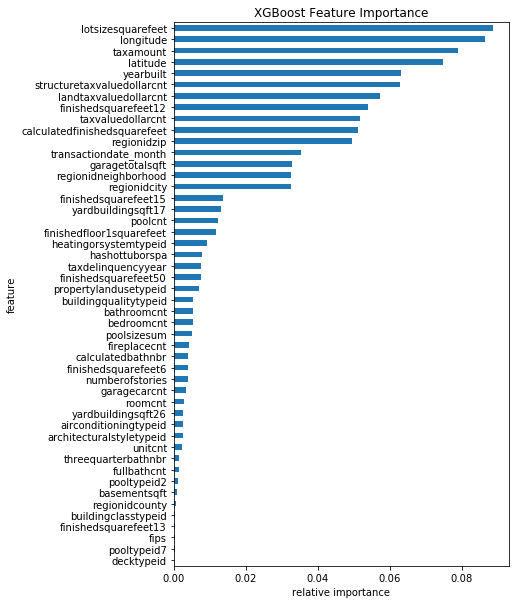

In [28]:
clf, subm = train_predict(props)

## Baseline MAE = 0.060681

# Stuff that work

In [9]:
# generator function for pulling out items a number at a time
def batch(s, n):
    for i in range(0, len(s), n):
        yield s[i:min(i+n, len(s))]
        
# test function
# display(props.columns)
# [c for c in batch(props.columns, 6)]

# for describing the data with DataFrameSummary
def summarize(df):
    for cols in batch(df.columns, 5):
        display(pds.DataFrameSummary(df[cols]).summary())
        
# test function
# describe(props)

# for showing data types, unique and missing values
def describe_values(df):
    stats = pd.DataFrame(columns=['column', 'dtype', 'sample', 'unique len', 'missing %'])
    for c in df.columns:
        stats.loc[-1] = [c, df[c].dtype, df[c].unique()[:3], len(df[c].unique()), df[c].isnull().sum(axis=0) / df[c].size * 100]
        stats.index += 1
    display(stats.set_index('column'))

In [35]:
clean = props.copy()
def pad(col, val=None, dtype=None):
    display(col)
    if col not in clean.columns: 
        clean[col] = props[col]
    display(clean[col].unique())
    if val != None:
        clean[col] = clean[col].fillna(val)
    if dtype != None:
        clean[col] = clean[col].astype(dtype)
    display(clean[col].unique())

In [36]:
pad('calculatedbathnbr', dtype='float64')

# if it doesn't have a value, we just get it from bathroomcnt
clean['calculatedbathnbr'] = clean['calculatedbathnbr'].fillna(clean['bathroomcnt'])
display(clean['calculatedbathnbr'].unique())

'calculatedbathnbr'

array([  nan,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

array([  nan,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,    nan,  18.  ,  16.  ,   1.75,
        17.  ,  19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [37]:
props.loc[props.rawcensustractandblock.isnull() & ~props.censustractandblock.isnull(), ['rawcensustractandblock', 'censustractandblock', 'fips']]

,rawcensustractandblock,censustractandblock,fips


In [38]:
clean['rawcensustractandblock'] = props['rawcensustractandblock'].astype('str')
clean['censustractandblock'] = props['censustractandblock']
clean['fips'] = clean['rawcensustractandblock'].str.slice(0, 4).replace('nan', None)
clean['tract'] = clean['rawcensustractandblock'].str.slice(4, 11).replace('', None)
clean['block'] = clean['rawcensustractandblock'].str.slice(11).replace('', None)

In [39]:
pad('rawcensustractandblock', None, 'float32');
pad('censustractandblock', None, 'float32');
pad('fips', None, 'int64');
pad('tract', None, 'float32');
pad('block', None, 'int64');

'rawcensustractandblock'

array(['60378002.041', '60378001.011', '60377030.012', ...,
       '60375039.0221', '60376024.03', 'nan'], dtype=object)

array([ 60378004.,  60378000.,  60377032.,  60371412.,  60371232.,
        60371252.,  60371436.,  60373108.,  60373100.,  60373204.,
        60371112.,  60379200.,  60379204.,  60379104.,  60379108.,
        60379008.,  60379004.,  60372348.,  60376008.,  60376012.,
        60376016.,  60376020.,  60372760.,  60376204.,  60377028.,
        60372756.,  60372724.,  60377012.,  60377024.,  60377020.,
        60377016.,  60372692.,  60372656.,  60372624.,  60372324.,
        60372212.,  60372172.,  60372164.,  60372328.,  60372080.,
        60372096.,  60371992.,  60372016.,  60372032.,  60375312.,
        60375304.,  60374812.,  60374816.,  60371976.,  60371872.,
        60371864.,  60371836.,  60371900.,  60377004.,  60371892.,
        60373012.,  60373008.,  60374620.,  60374636.,  60374316.,
        60374600.,  60374616.,  60372392.,  60372376.,  60372384.,
        60372404.,  60372408.,  60372912.,  60375408.,  60375360.,
        60375536.,  60375332.,  60375340.,  60375324.,  603753

'censustractandblock'

array([             nan,   6.11100100e+13,   6.11100090e+13, ...,
         6.05909924e+13,   6.05906264e+13,   6.03790121e+13])

array([             nan,   6.11100110e+13,   6.11100068e+13,
         6.11100026e+13,   6.11100152e+13,   6.11100194e+13,
         6.11100236e+13,   6.11100278e+13,   6.11100530e+13,
         6.11100320e+13,   6.11100488e+13,   6.11100572e+13,
         6.11100865e+13,   6.11100362e+13,   6.11100446e+13,
         6.11100907e+13,   6.11100404e+13,   6.11100781e+13,
         6.11100614e+13,   6.11100656e+13,   6.11100698e+13,
         6.11100740e+13,   6.11100823e+13,   6.03713438e+13,
         6.03713522e+13,   6.03713731e+13,   6.03780001e+13,
         6.03780043e+13,   6.03713144e+13,   6.03713102e+13,
         6.03713186e+13,   6.03713396e+13,   6.03713480e+13,
         6.03713228e+13,   6.03713270e+13,   6.03713312e+13,
         6.03713689e+13,   6.03713941e+13,   6.03713899e+13,
         6.03713815e+13,   6.03713983e+13,   6.03712725e+13,
         6.03712012e+13,   6.03712809e+13,   6.03712767e+13,
         6.03712850e+13,   6.03712892e+13,   6.03714151e+13,
         6.03714109e+13,

'fips'

array(['6037', '6059', '6111'], dtype=object)

array([6037, 6059, 6111])

'tract'

array(['8002.04', '8001.01', '7030.01', ..., '2260.00', '9203.35',
       '2145.03'], dtype=object)

array([ 8002.04003906,  8001.00976562,  7030.00976562, ...,  2260.        ,
        9203.34960938,  2145.0300293 ])

'block'

array(['1', '2', '3', '11', '4', '7', '5', '31', '21', '12', '41', '6',
       '51', '32', '13', '15', '16', '14', '8', '22', '9', '42', '18',
       '23', '33', '71', '17', '24', '19', '61', '25'], dtype=object)

array([ 1,  2,  3, 11,  4,  7,  5, 31, 21, 12, 41,  6, 51, 32, 13, 15, 16,
       14,  8, 22,  9, 42, 18, 23, 33, 71, 17, 24, 19, 61, 25])

In [40]:
clean.loc[:, ('fips', 'tract', 'block')].head()

,fips,tract,block
0,6037,8002.040039,1
1,6037,8001.009766,1
2,6037,7030.009766,2
3,6037,1412.020020,3
4,6037,1232.050049,2


In [41]:
# investigate yearbuilt

#df = props[['structuretaxvaluedollarcnt', 'yearbuilt']].dropna()
#df.plot.scatter(x='yearbuilt', y='structuretaxvaluedollarcnt')

col = 'yearbuilt'
clean['yearbuilt'] = props['yearbuilt']
display(np.sort(clean[col].unique()))
pad('yearbuilt', 2016)

array([ 1801.,  1805.,  1806.,  1807.,  1808.,  1810.,  1812.,  1815.,
        1819.,  1821.,  1823.,  1824.,  1825.,  1827.,  1828.,  1829.,
        1831.,  1833.,  1834.,  1840.,  1853.,  1855.,  1859.,  1862.,
        1865.,  1870.,  1874.,  1875.,  1876.,  1877.,  1878.,  1879.,
        1880.,  1881.,  1882.,  1883.,  1884.,  1885.,  1886.,  1887.,
        1888.,  1889.,  1890.,  1891.,  1892.,  1893.,  1894.,  1895.,
        1896.,  1897.,  1898.,  1899.,  1900.,  1901.,  1902.,  1903.,
        1904.,  1905.,  1906.,  1907.,  1908.,  1909.,  1910.,  1911.,
        1912.,  1913.,  1914.,  1915.,  1916.,  1917.,  1918.,  1919.,
        1920.,  1921.,  1922.,  1923.,  1924.,  1925.,  1926.,  1927.,
        1928.,  1929.,  1930.,  1931.,  1932.,  1933.,  1934.,  1935.,
        1936.,  1937.,  1938.,  1939.,  1940.,  1941.,  1942.,  1943.,
        1944.,  1945.,  1946.,  1947.,  1948.,  1949.,  1950.,  1951.,
        1952.,  1953.,  1954.,  1955.,  1956.,  1957.,  1958.,  1959.,
      

'yearbuilt'

array([   nan,  1948.,  1947.,  1943.,  1946.,  1978.,  1958.,  1949.,
        1956.,  2005.,  1957.,  1939.,  1926.,  1938.,  1972.,  1955.,
        2004.,  2011.,  1929.,  2010.,  1934.,  1925.,  1936.,  1920.,
        1937.,  1962.,  1927.,  1908.,  1909.,  1959.,  1916.,  1993.,
        1960.,  1919.,  1942.,  1940.,  1924.,  2006.,  1950.,  1923.,
        1912.,  1935.,  1953.,  1985.,  1944.,  1951.,  1973.,  2003.,
        1992.,  1952.,  1969.,  1921.,  1981.,  2000.,  1961.,  1989.,
        1970.,  2009.,  1984.,  1968.,  1999.,  1964.,  1991.,  1983.,
        1982.,  1977.,  1995.,  1994.,  1986.,  1965.,  1974.,  1980.,
        1987.,  1967.,  1990.,  2002.,  1963.,  1971.,  1975.,  1997.,
        1976.,  1979.,  1988.,  1998.,  2013.,  2014.,  2012.,  1932.,
        1966.,  1954.,  1904.,  1928.,  1930.,  1941.,  1890.,  2001.,
        1996.,  2008.,  1913.,  1933.,  2007.,  1931.,  1945.,  1922.,
        1910.,  1918.,  1914.,  1911.,  1907.,  1915.,  1905.,  1902.,
      

array([ 2016.,  1948.,  1947.,  1943.,  1946.,  1978.,  1958.,  1949.,
        1956.,  2005.,  1957.,  1939.,  1926.,  1938.,  1972.,  1955.,
        2004.,  2011.,  1929.,  2010.,  1934.,  1925.,  1936.,  1920.,
        1937.,  1962.,  1927.,  1908.,  1909.,  1959.,  1916.,  1993.,
        1960.,  1919.,  1942.,  1940.,  1924.,  2006.,  1950.,  1923.,
        1912.,  1935.,  1953.,  1985.,  1944.,  1951.,  1973.,  2003.,
        1992.,  1952.,  1969.,  1921.,  1981.,  2000.,  1961.,  1989.,
        1970.,  2009.,  1984.,  1968.,  1999.,  1964.,  1991.,  1983.,
        1982.,  1977.,  1995.,  1994.,  1986.,  1965.,  1974.,  1980.,
        1987.,  1967.,  1990.,  2002.,  1963.,  1971.,  1975.,  1997.,
        1976.,  1979.,  1988.,  1998.,  2013.,  2014.,  2012.,  1932.,
        1966.,  1954.,  1904.,  1928.,  1930.,  1941.,  1890.,  2001.,
        1996.,  2008.,  1913.,  1933.,  2007.,  1931.,  1945.,  1922.,
        1910.,  1918.,  1914.,  1911.,  1907.,  1915.,  1905.,  1902.,
      

[0]	train-logloss:0.692679	valid-logloss:0.692506
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[20]	train-logloss:0.686143	valid-logloss:0.682271
[40]	train-logloss:0.682306	valid-logloss:0.67576
[60]	train-logloss:0.679794	valid-logloss:0.671217
[80]	train-logloss:0.677984	valid-logloss:0.668423
[100]	train-logloss:0.67648	valid-logloss:0.666454
[120]	train-logloss:0.67523	valid-logloss:0.665268
[140]	train-logloss:0.674168	valid-logloss:0.664214
[160]	train-logloss:0.673236	valid-logloss:0.663493
[180]	train-logloss:0.672402	valid-logloss:0.662964
[200]	train-logloss:0.671637	valid-logloss:0.662362
[220]	train-logloss:0.6709	valid-logloss:0.66209
[240]	train-logloss:0.67015	valid-logloss:0.661795
[260]	train-logloss:0.669552	valid-logloss:0.661548
[280]	train-logloss:0.668887	valid-logloss:0.661291
[300]	train-logloss:0.66827	valid-logloss:0.661181
[320]	train-logloss:0.66771	va

(<xgboost.core.Booster at 0x7fc793ffb828>, None)

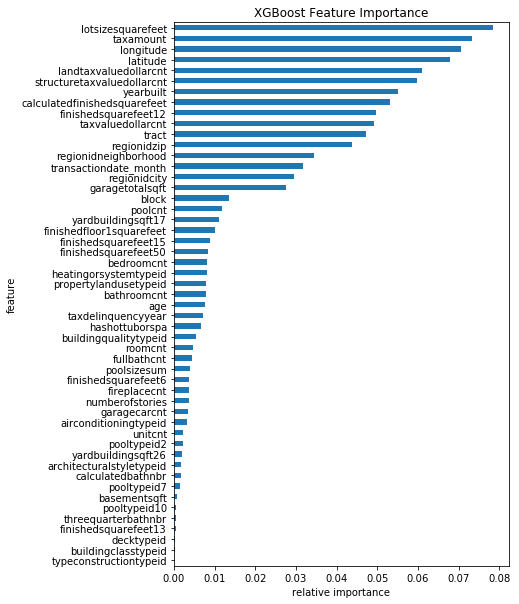

In [49]:
params = {
    'eta': 0.02,
#     'objective': 'reg:linear',
#     'eval_metric': 'mae',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',        
    'max_depth': 4,
    'silent': 1,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
#     'gamma': 2,
#     'alpha': 2,
}

train_predict(clean, params)

# Experiments

In [ ]:
# check if there are multiple transactions in a month

merged = train.merge(props, how='left', on='parcelid')
merged = df_train = split_date(merged, 'transactiondate')
merged.loc[merged.duplicated(['parcelid', 'transactiondate_year', 'transactiondate_month'], keep=False)]

In [ ]:
# check if all the properties are represented in the required submission

diff = set(props['parcelid']) - set(sample['ParcelId'])
display(len(diff) == 0)

In [55]:
train = pd.read_csv('zillow/train_2016_v2.csv')

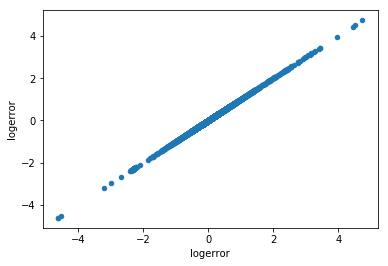

In [87]:
# check for outliers
pd.DataFrame(train['logerror']).plot.scatter(x='logerror', y='logerror')

In [90]:
summarize(pd.DataFrame(train['logerror']))

,logerror
count,90275
mean,0.0114572
std,0.161079
min,-4.605
25%,-0.0253
50%,0.006
75%,0.0392
max,4.737
counts,90275
uniques,1894


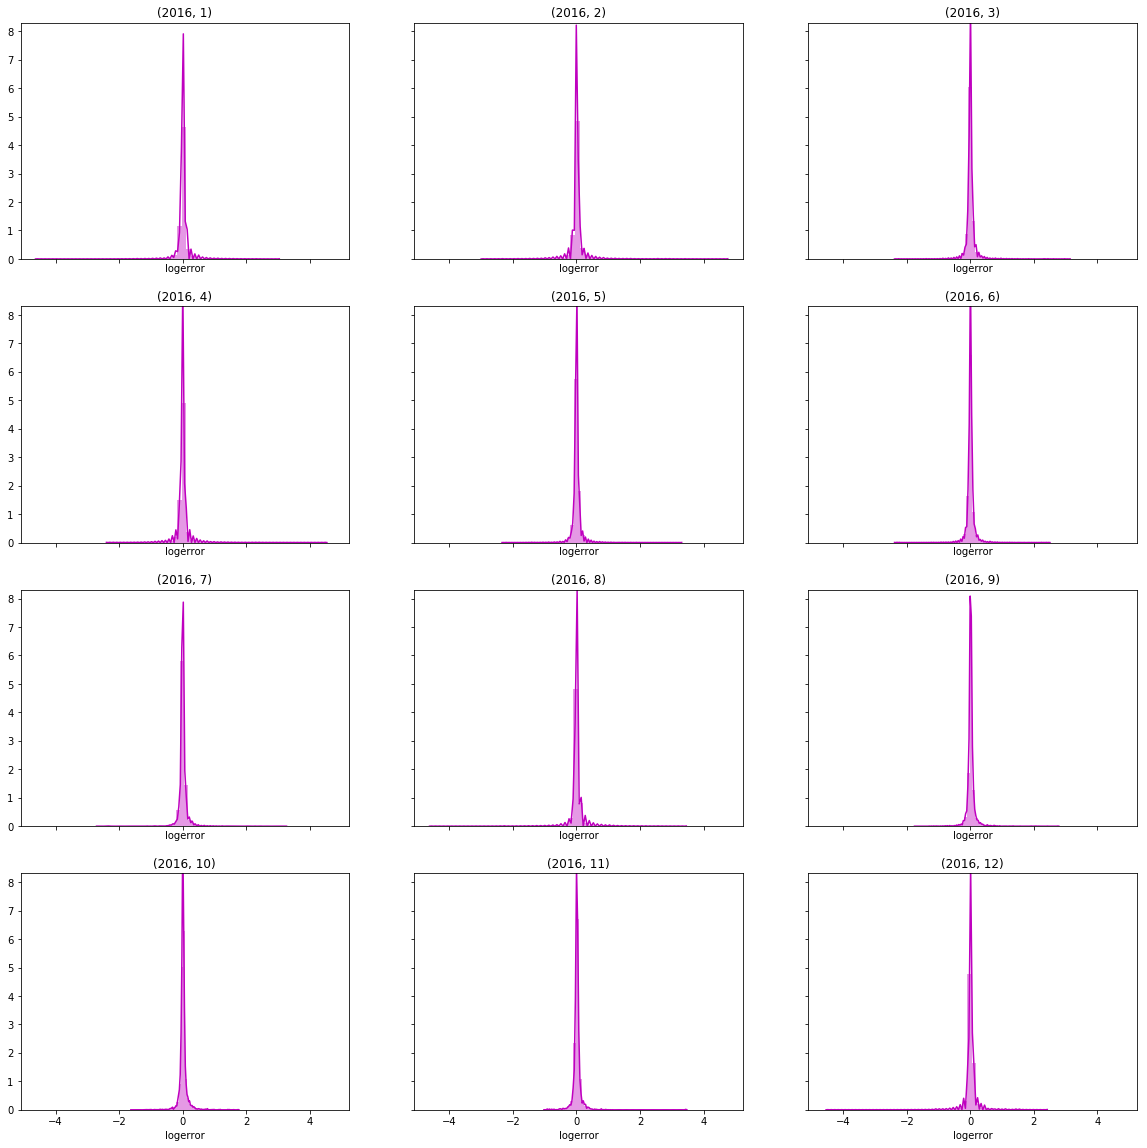

In [83]:
# see if logerror varies per month

tx = 'transactiondate'
df_train = split_date(train, tx).groupby([tx+'_year', tx+'_month'])
f, axes = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(20, 20))
for axis, (idx, df) in zip(itertools.chain(*axes), df_train):
#     axis.set(yscale="log")
#     display(axis)
#     display(df_train)
    sns.distplot(df['logerror'], color="m", ax=axis).set_title(idx)

In [11]:
pad('airconditioningtypeid', 0, 'int64')

'airconditioningtypeid'

array([ nan,   1.,  13.,   5.,  11.,   9.,  12.,   3.])

array([ 0,  1, 13,  5, 11,  9, 12,  3])

In [12]:
pad('architecturalstyletypeid', 0, 'int64')

'architecturalstyletypeid'

array([ nan,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])

array([ 0,  7, 21,  8,  2,  3,  5, 10, 27])

In [13]:
pad('basementsqft', 0, 'int64')

'basementsqft'

array([   nan,   216.,   555.,   224.,   782.,   651.,   516.,   600.,
         732.,  1145.,   220.,   420.,   688.,   144.,   540.,  1312.,
         690.,   640.,   550.,    63.,   198.,  1120.,   924.,  1572.,
        1035.,   195.,   544.,   498.,   176.,   360.,   154.,   240.,
         616.,  1131.,   200.,  1016.,  1089.,  2443.,   276.,   396.,
         149.,   168.,   495.,   208.,   560.,   939.,   704.,   460.,
        1152.,   462.,  1904.,   888.,   170.,   625.,   450.,    72.,
         252.,   637.,    96.,  1172.,  1464.,   787.,   501.,   473.,
         318.,   112.,   394.,   985.,   169.,   400.,   826.,   780.,
        1350.,   610.,  1528.,   255.,   164.,   315.,   836.,   630.,
         160.,  1508.,   775.,   676.,   448.,   756.,   912.,   179.,
         700.,   348.,   595.,   231.,   100.,   266.,   620.,   757.,
         786.,   872.,   672.,   831.,  1544.,   946.,   180.,   313.,
         314.,   440.,   528.,    36.,   320.,   515.,   196.,   119.,
      

array([   0,  216,  555,  224,  782,  651,  516,  600,  732, 1145,  220,
        420,  688,  144,  540, 1312,  690,  640,  550,   63,  198, 1120,
        924, 1572, 1035,  195,  544,  498,  176,  360,  154,  240,  616,
       1131,  200, 1016, 1089, 2443,  276,  396,  149,  168,  495,  208,
        560,  939,  704,  460, 1152,  462, 1904,  888,  170,  625,  450,
         72,  252,  637,   96, 1172, 1464,  787,  501,  473,  318,  112,
        394,  985,  169,  400,  826,  780, 1350,  610, 1528,  255,  164,
        315,  836,  630,  160, 1508,  775,  676,  448,  756,  912,  179,
        700,  348,  595,  231,  100,  266,  620,  757,  786,  872,  672,
        831, 1544,  946,  180,  313,  314,  440,  528,   36,  320,  515,
        196,  119, 3374,  606,  736,  678, 1282,  135,   64,  506,  414,
       1296, 1197, 1112,  814,  530,  165, 1314,  352,  282,  293,  805,
       2025,  990,  173,  841,  108,  140,  280,  853,  751,  150, 1226,
         25,  384, 1552,  689,  656,  795, 1560,  8

In [15]:
display(props['bathroomcnt'].median())
pad('bathroomcnt', props['bathroomcnt'].median(), 'float64')

2.0

'bathroomcnt'

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [17]:
display(props['bedroomcnt'].median())
pad('bedroomcnt', props['bedroomcnt'].median(), 'float64')

3.0

'bedroomcnt'

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  nan,  15.,  17.,  18.,  20.,  19.])

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  15.,  17.,  18.,  20.,  19.])

In [20]:
pad('buildingclasstypeid', 0, 'int64')

'buildingclasstypeid'

array([ nan,   3.,   4.,   5.,   2.,   1.])

array([0, 3, 4, 5, 2, 1])

In [21]:
pad('buildingqualitytypeid', 0, 'int64')

'buildingqualitytypeid'

array([ nan,   7.,   4.,  10.,   1.,  12.,   8.,   3.,   6.,   9.,   5.,
        11.,   2.])

array([ 0,  7,  4, 10,  1, 12,  8,  3,  6,  9,  5, 11,  2])

In [25]:
pad('decktypeid', 0, 'int64')

'decktypeid'

array([ 0, 66])

array([ 0, 66])

In [49]:
area_features = [
#                  'lotsizesquarefeet', 
                 'finishedsquarefeet6', 
                 'finishedsquarefeet15', 
                 'finishedsquarefeet13', 
                 'calculatedfinishedsquarefeet', 
                 'finishedsquarefeet12', 
                 'finishedfloor1squarefeet',
                 'finishedsquarefeet50',
                ]

area_features.reverse()

def fill_null(col1, col2):
#     display("{} <== {}".format(col1, col2))
    clean[col1] = clean[col1].fillna(clean[col2])

for col in area_features:
    clean[col] = props[col]
    
# fill_null('lotsizesquarefeet', 'finishedsquarefeet15')
    


# describe_values(clean.loc[:, area_features])
    
# for col1, col2 in itertools.permutations(area_features, 2):
#     fill_null(col1, col2)
    
# describe_values(clean.loc[:, area_features])

# for col in area_features:
#     pad(col, clean[col].mean(), 'float32')

# describe_values(clean.loc[:, area_features])

[0]	train-mae:0.48802	valid-mae:0.480594
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.332731	valid-mae:0.325219
[40]	train-mae:0.231465	valid-mae:0.224249
[60]	train-mae:0.16641	valid-mae:0.159674
[80]	train-mae:0.125338	valid-mae:0.119143
[100]	train-mae:0.10027	valid-mae:0.09451
[120]	train-mae:0.08563	valid-mae:0.080356
[140]	train-mae:0.07753	valid-mae:0.072822
[160]	train-mae:0.0732	valid-mae:0.069003
[180]	train-mae:0.070928	valid-mae:0.067156
[200]	train-mae:0.069716	valid-mae:0.066286
[220]	train-mae:0.069073	valid-mae:0.065886
[240]	train-mae:0.06872	valid-mae:0.065702
[260]	train-mae:0.068519	valid-mae:0.065617
[280]	train-mae:0.068399	valid-mae:0.065578
[300]	train-mae:0.068326	valid-mae:0.065559
[320]	train-mae:0.06828	valid-mae:0.06555
[340]	train-mae:0.068251	valid-mae:0.065545
[360]	train-mae:0.068232	valid-mae:0.065542
[380]	train-mae:0.06822	valid-mae:0.0

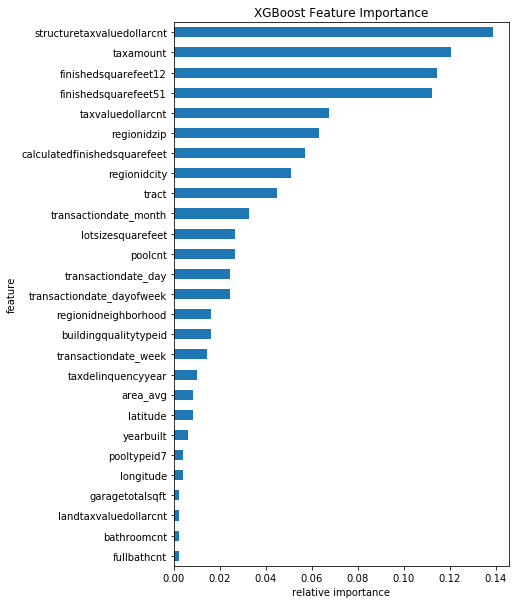

In [53]:
clean['area_avg'] = props[area_features].mean(axis=1)
clean['finishedsquarefeet12'] = props['finishedsquarefeet12']
ratio = clean['finishedsquarefeet12'].mean() / clean['lotsizesquarefeet'].mean()
clean['finishedsquarefeet51'] = clean['finishedsquarefeet12'].fillna(clean['lotsizesquarefeet'] * ratio)
# describe_values(clean)
train_predict(clean)

In [96]:
pad('fireplacecnt', 0, 'int64')

'fireplacecnt'

array([ nan,   3.,   1.,   2.,   4.,   9.,   5.,   7.,   6.,   8.])

array([0, 3, 1, 2, 4, 9, 5, 7, 6, 8])

In [97]:
pad('fullbathcnt', 0, 'int64')

'fullbathcnt'

array([ nan,   2.,   4.,   3.,   1.,   5.,   7.,   6.,  10.,   8.,   9.,
        12.,  11.,  13.,  14.,  20.,  19.,  15.,  18.,  16.,  17.])

array([ 0,  2,  4,  3,  1,  5,  7,  6, 10,  8,  9, 12, 11, 13, 14, 20, 19,
       15, 18, 16, 17])

In [99]:
pad('garagecarcnt', 0, 'int64')

'garagecarcnt'

array([ nan,   2.,   4.,   1.,   3.,   0.,   5.,   7.,   6.,   8.,   9.,
        12.,  11.,  10.,  13.,  14.,  15.,  25.,  21.,  18.,  17.,  24.,
        19.,  16.,  20.])

array([ 0,  2,  4,  1,  3,  5,  7,  6,  8,  9, 12, 11, 10, 13, 14, 15, 25,
       21, 18, 17, 24, 19, 16, 20])

In [102]:
pad('garagetotalsqft', 0, 'float32')

'garagetotalsqft'

array([   nan,   420.,   525., ...,  2482.,  4568.,  1974.])

array([    0.,   420.,   525., ...,  2482.,  4568.,  1974.])

In [119]:
clean['hashottuborspa'] = (props['hashottuborspa'] == True)
pad('hashottuborspa')
clean['fireplaceflag'] = (props['fireplaceflag'] == True)
pad('fireplaceflag')
clean['taxdelinquencyflag'] = (props['taxdelinquencyflag'] == 'Y')
pad('taxdelinquencyflag')

'hashottuborspa'

array([False,  True], dtype=bool)

array([False,  True], dtype=bool)

'fireplaceflag'

array([False,  True], dtype=bool)

array([False,  True], dtype=bool)

'taxdelinquencyflag'

array([False,  True], dtype=bool)

array([False,  True], dtype=bool)

In [121]:
pad('heatingorsystemtypeid', 0, np.int64)

'heatingorsystemtypeid'

array([ nan,   2.,   7.,  20.,   6.,  13.,  18.,  24.,  12.,  10.,   1.,
        14.,  21.,  11.,  19.])

array([ 0,  2,  7, 20,  6, 13, 18, 24, 12, 10,  1, 14, 21, 11, 19])

In [123]:
pad('poolcnt', 0, np.int64)

'poolcnt'

array([False,  True], dtype=bool)

array([0, 1])

In [149]:
clean['poolsizesum'] = props['poolsizesum']
clean.loc[clean.poolcnt > 0,('poolsizesum')] = clean.loc[clean.poolcnt > 0,('poolsizesum')].fillna(props['poolsizesum'])
pad('poolsizesum', 0, 'int64')

'poolsizesum'

array([    nan,    800.,    450.,    503.,    735.,    903.,    400.,
           70.,    648.,    645.,    475.,    324.,    610.,    840.,
          576.,    720.,    640.,    449.,    702.,    448.,    420.,
          385.,    629.,    782.,    360.,    578.,    480.,    496.,
          380.,    490.,    810.,    390.,    529.,    429.,    560.,
          691.,    555.,    512.,    723.,    570.,    518.,     64.,
          680.,    350.,    627.,    541.,    404.,    320.,    630.,
          600.,    684.,    376.,    750.,    352.,    590.,    410.,
          900.,    761.,    525.,    469.,    342.,    442.,    620.,
          540.,    660.,    462.,    440.,    220.,    579.,   1064.,
          588.,    563.,    384.,    739.,    486.,    435.,    405.,
          554.,    599.,    888.,    264.,    700.,    756.,    544.,
          527.,    375.,    520.,    472.,    632.,    495.,    272.,
          614.,    500.,    457.,    467.,    325.,    432.,    510.,
          795.,    5

array([    0,   800,   450,   503,   735,   903,   400,    70,   648,
         645,   475,   324,   610,   840,   576,   720,   640,   449,
         702,   448,   420,   385,   629,   782,   360,   578,   480,
         496,   380,   490,   810,   390,   529,   429,   560,   691,
         555,   512,   723,   570,   518,    64,   680,   350,   627,
         541,   404,   320,   630,   600,   684,   376,   750,   352,
         590,   410,   900,   761,   525,   469,   342,   442,   620,
         540,   660,   462,   440,   220,   579,  1064,   588,   563,
         384,   739,   486,   435,   405,   554,   599,   888,   264,
         700,   756,   544,   527,   375,   520,   472,   632,   495,
         272,   614,   500,   457,   467,   325,   432,   510,   795,
         558,   575,   370,   580,   392,   550,   538,   240,   300,
         557,   583,   902,   584,   271,   407,   284,   337,   675,
        1800,   248,   470,   441,   830,   635,   460,   340,   612,
         336,   622,

In [153]:
pad('pooltypeid10', 0, 'int64')
pad('pooltypeid2', 0, 'int64')
pad('pooltypeid7', 0, 'int64')

'pooltypeid10'

array([ nan,   1.])

array([0, 1])

'pooltypeid2'

array([ nan,   1.])

array([0, 1])

'pooltypeid7'

array([ nan,   1.])

array([0, 1])

In [155]:
pad('regionidcity')

'regionidcity'

array([  37688.,   51617.,   12447.,  396054.,   47547.,      nan,
         54311.,   40227.,    5534.,   45888.,   33612.,   26964.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,   12520.,  118217.,   54212.,   45398.,   24174.,
         30267.,   21778.,   10723.,  118878.,   22827.,    5465.,
         36502.,   45602.,   39308.,   33836.,   24245.,   32923.,
         37015.,   24812.,   34780.,   52650.,   46314.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   40110.,   18098.,
         13311.,   51239.,   34037.,   47198.,   25974.,   416

array([  37688.,   51617.,   12447.,  396054.,   47547.,      nan,
         54311.,   40227.,    5534.,   45888.,   33612.,   26964.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,   12520.,  118217.,   54212.,   45398.,   24174.,
         30267.,   21778.,   10723.,  118878.,   22827.,    5465.,
         36502.,   45602.,   39308.,   33836.,   24245.,   32923.,
         37015.,   24812.,   34780.,   52650.,   46314.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   40110.,   18098.,
         13311.,   51239.,   34037.,   47198.,   25974.,   416

In [33]:
from sklearn.neighbors import KNeighborsClassifier

def fill_with_NN(df, col):
    df_train = df[~df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull()]
    df_pred = df[df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull()]
    display(df_train)
    display(df_pred)
    X = df_train.loc[:, ('longitude', 'latitude')].astype('float32')
    y = df_train[col]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X, y)
    df.loc[df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull(), (col)] = knn.predict(df_pred.loc[:, ('longitude', 'latitude')])
    display(preds)

pad('regionidcity')
pad('latitude')
pad('longitude')
fill_with_NN(clean, 'regionidcity')

describe_values(clean)
# regionidneighborhood

'regionidcity'

array([  37688.,   51617.,   12447.,  396054.,   47547.,   54311.,
         40227.,    5534.,   45888.,   33612.,   26964.,   12520.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,  118217.,   54212.,   45398.,   24174.,   30267.,
         21778.,   10723.,  118878.,   22827.,    5465.,   36502.,
         45602.,   39308.,   33836.,   24245.,   32923.,   37015.,
         24812.,   34780.,   52650.,   46314.,   38032.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   25468.,   42150.,
         40110.,   18098.,   13311.,   51239.,   34037.,   471

array([  37688.,   51617.,   12447.,  396054.,   47547.,   54311.,
         40227.,    5534.,   45888.,   33612.,   26964.,   12520.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,  118217.,   54212.,   45398.,   24174.,   30267.,
         21778.,   10723.,  118878.,   22827.,    5465.,   36502.,
         45602.,   39308.,   33836.,   24245.,   32923.,   37015.,
         24812.,   34780.,   52650.,   46314.,   38032.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   25468.,   42150.,
         40110.,   18098.,   13311.,   51239.,   34037.,   471

'latitude'

array([ 34144442.,  34140430.,  33989359., ...,  33525063.,  33634876.,
              nan])

array([ 34144442.,  34140430.,  33989359., ...,  33525063.,  33634876.,
              nan])

'longitude'

array([ -1.18654084e+08,  -1.18625364e+08,  -1.18394633e+08, ...,
        -1.18845451e+08,  -1.17801513e+08,              nan])

array([ -1.18654084e+08,  -1.18625364e+08,  -1.18394633e+08, ...,
        -1.18845451e+08,  -1.17801513e+08,              nan])

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,...,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.76,NaN,NaN,NaN


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [174]:
pad('taxdelinquencyyear')

'taxdelinquencyyear'

array([ nan,  13.,  15.,  11.,  14.,   9.,  10.,   8.,  12.,   7.,   6.,
         2.,  92.,   5.,   3.,   4.,  95.,  91.,  93.,  98.,  82.,  79.,
        94.,  97.,  90.,  99.,   0.,   1.,  87.,  84.,  86.,  88.,  96.])

array([ nan,  13.,  15.,  11.,  14.,   9.,  10.,   8.,  12.,   7.,   6.,
         2.,  92.,   5.,   3.,   4.,  95.,  91.,  93.,  98.,  82.,  79.,
        94.,  97.,  90.,  99.,   0.,   1.,  87.,  84.,  86.,  88.,  96.])

In [261]:
# categorical columns
cat_cols = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
            'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10', 
            'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 
            'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
            'regionidzip', 'storytypeid', 'typeconstructiontypeid', 'fireplaceflag', 'assessmentyear', 
            'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'yearbuilt']

# stuff splitting the date
cat_cols.extend(['transactiondate_day', 'transactiondate_dayofweek', 'transactiondate_month', 
                 'transactiondate_week', 'transactiondate_year'])

# columns we'll drop
drop_cols = ['transactiondate', 'parcelid', 'logerror']

# continuous columns
cont_cols = set(merged.columns) - set(cat_cols) - set(drop_cols)

display(cont_cols)

{'age',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'landtaxvaluedollarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'taxvaluedollarcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [262]:
for c in cat_cols:
    merged[c] = merged[c].astype('str')
    merged[c].fillna("")
    merged[c] = merged[c].astype('category')
for c in cont_cols: 
    merged.loc[merged[c].isnull(), c] = 0
    
#describe(merged)

In [263]:
#see if all properties have test data
subm = pd.read_csv('zillow/sample_submission.csv')

# describe(subm)

In [264]:
# see how much training data we have

# total props in submission
display(subm['ParcelId'].count())

# submission vs property data
display(subm[~subm['ParcelId'].isin(props['parcelid'])]['ParcelId'].count())

# submission vs training data
display(subm[~subm['ParcelId'].isin(train['parcelid'])]['ParcelId'].count())

2985217

0

2895067

In [265]:
X = merged.drop(drop_cols, axis=1)
X = merged.drop('logerror', axis=1)
y = merged['logerror']

In [266]:
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
cont_maps = [([c], StandardScaler()) for c in cont_cols]

In [267]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(X)
len(cat_map_fit.features)

32

In [268]:
cont_mapper = DataFrameMapper(cont_maps)
cont_map_fit = cont_mapper.fit(X)
len(cont_map_fit.features)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


31

In [269]:
X_cat = cat_mapper.transform(X).astype(np.int64)
X_cont = cont_mapper.transform(X).astype(np.float32)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [270]:
X_all = np.concatenate([X_cat, X_cont], axis=1)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.1)

In [272]:
train = xgboost.DMatrix(X_train, y_train, feature_names=cat_cols + list(cont_cols))
test = xgboost.DMatrix(X_test, y_test, feature_names=cat_cols + list(cont_cols))

In [285]:
xgb_parms = {'eta': 0.01, 'max_depth': 6, 'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': 1}

In [286]:
xgb_parms['seed'] = random.randint(0,1e9)
watchlist = [(train, 'train'), (test, 'test')]
xgbmodel = xgboost.train(xgb_parms, train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=50)

[0]	train-mae:0.492253	test-mae:0.490514
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 100 rounds.
[50]	train-mae:0.306081	test-mae:0.304423
[100]	train-mae:0.196957	test-mae:0.195456
[150]	train-mae:0.134524	test-mae:0.133135
[200]	train-mae:0.100185	test-mae:0.098941
[250]	train-mae:0.082543	test-mae:0.081343
[300]	train-mae:0.074129	test-mae:0.073052
[350]	train-mae:0.070293	test-mae:0.069268
[400]	train-mae:0.068527	test-mae:0.067582
[450]	train-mae:0.067659	test-mae:0.066816
[500]	train-mae:0.067184	test-mae:0.066461
[550]	train-mae:0.066905	test-mae:0.066294
[600]	train-mae:0.06671	test-mae:0.066228
[650]	train-mae:0.066561	test-mae:0.066205
[700]	train-mae:0.066428	test-mae:0.066199
[750]	train-mae:0.066313	test-mae:0.066208
[800]	train-mae:0.066198	test-mae:0.066253
Stopping. Best iteration:
[732]	train-mae:0.066353	test-mae:0.066193



In [287]:
xgbmodel.eval(test)

b'[0]\teval-mae:0.066267'